## Imports and Setup

In [ ]:
import os
import pandas as pd
import geopandas as gpd
import logging
import joblib
import torch

import sys
sys.path.insert(0, "../utils/")
import eval_utils
import config_utils

%load_ext autoreload
%autoreload 2

## Load Config Files

In [145]:
iso_code = "GHA"
cwd = os.path.dirname(os.getcwd())
data_config_file = os.path.join(cwd, "configs/AF_config.yaml")
data_config = config_utils.load_config(data_config_file)

model_config_file = os.path.join(cwd, "configs/cnn_configs/convnext_small_v01.yaml")
model_config = config_utils.load_config(model_config_file)

## Load Results

In [146]:
exp_name = f"{iso_code}_{model_config['config_name']}"
output_path = os.path.join(
    cwd,  model_config["exp_dir"], model_config["project"], exp_name, f"{exp_name}_test.csv"
)
output = pd.read_csv(output_path)
output.head(3)

,UID,source,iso,country,region,subregion,name,giga_id_school,clean,validated,class,ghsl_smod,rurban,dataset,geometry,y_true,y_preds,y_probs
0,OVERTURE-GHA-SCHOOL-00000014,OVERTURE,GHA,Ghana,Africa,Sub-Saharan Africa,Presby Primary School Komfourkrom-A,NaN,0,0.0,school,22,urban,test,POINT (-125479.69839610334 981718.2290214166),1,1,0.758218
1,OVERTURE-GHA-SCHOOL-00000037,OVERTURE,GHA,Ghana,Africa,Sub-Saharan Africa,Sefwi Bekwai Senior High School - Sebess,NaN,0,0.0,school,12,rural,test,POINT (-230938.83421113284 766390.0024152958),1,1,0.931291
2,OVERTURE-GHA-SCHOOL-00000077,OVERTURE,GHA,Ghana,Africa,Sub-Saharan Africa,Beverly Hills Academy Hohoe,NaN,0,0.0,school,30,urban,test,POINT (46935.65844086759 883156.8575174323),1,1,0.831925


## Run Evaluation

In [147]:
results = eval_utils.evaluate(
    y_true=output["y_true"], 
    y_pred=output["y_preds"], 
    y_prob=output["y_probs"], 
    pos_label=1, 
    neg_label=0, 
)
optim_threshold, fscores = eval_utils.get_optimal_threshold(
    results['precision_scores_50_'],  
    results['recall_scores_50_'], 
    results['thresholds_50_'], 
    beta=0.5
)
recalls = results['recall_scores_50_'][1:]
precisions = results['precision_scores_50_'][1:]
thresholds = results['thresholds_50_'][1:]

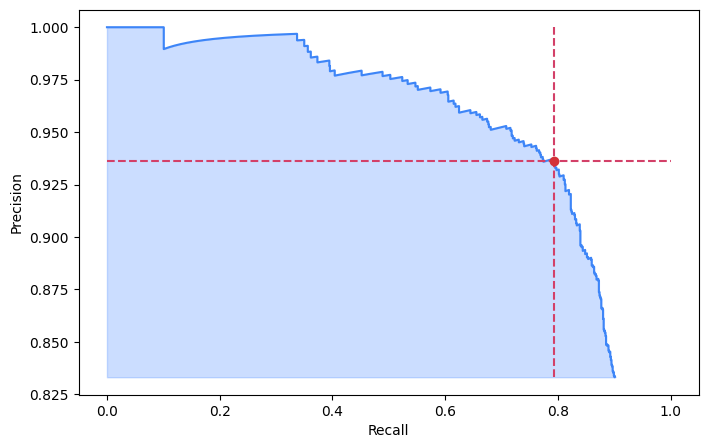

In [148]:
import matplotlib.pyplot as plt
import numpy as np

BLUE = "#3D85F7"
BLUE_LIGHT = "#5490FF"
PINK = "#d43139ff"
PINK_LIGHT = "#D34068"

fig, ax = plt.subplots(figsize=(8, 5))
ix = np.argmax(fscores[:-1])
ax.scatter(
    recalls[ix], 
    precisions[ix], 
    marker='o', 
    color=PINK,
    zorder=10
)
ax.plot(
    recalls, 
    precisions, 
    linestyle='-',
    color=BLUE
)
ymin = np.min(precisions)
ax.fill_between(
    recalls, 
    ymin,
    precisions, 
    interpolate=True, 
    color=BLUE_LIGHT, 
    alpha=0.3
)
ax.plot(
    [0, 1], 
    [precisions[ix], precisions[ix]], 
    linestyle='--',
    color=PINK_LIGHT
)
ax.plot(
    [recalls[ix], recalls[ix]],
    [1, np.min(precisions)],  
    linestyle='--',
    color=PINK_LIGHT
)
ax.set_ylabel("Precision")
ax.set_xlabel("Recall");